In [5]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import dask_geopandas
import contextily as ctx
import seaborn as sns


In [6]:
panel = gpd.read_feather('../data/panel_data_estimated_costs.geofeather')

In [7]:
# Update x, y to be based on parcel shapefile geometry and not tax shapefile geometry
panel['x'] = panel.geometry.centroid.x
panel['y'] = panel.geometry.centroid.y

In [8]:
panel = panel[panel['geometry'].notna()]

### Unit count data

In [9]:
homes = pd.read_excel('../data/Housing Production 2005-2022.xlsx')

In [10]:
dbi = gpd.read_feather('../data/dbi_permits.geofeather')

In [11]:
date_cols = [c for c in dbi.columns if 'date' in c]
dbi[date_cols] = dbi[date_cols].apply(lambda x: pd.to_datetime(x, errors='coerce'))
cost_cols = [c for c in dbi.columns if 'cost' in c]
dbi[cost_cols] = dbi[cost_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
unit_cols = [c for c in dbi.columns if 'unit' in c]
dbi[unit_cols] = dbi[unit_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [12]:
dbi = dbi.sort_values('permit_creation_date', ascending=False)
dbi = dbi.drop_duplicates('permit_number')

# NB: 5 rows in homes don't match-
permits = pd.merge(dbi[['geometry', 'permit_number', 'permit_creation_date']],
                   homes,
                   left_on='permit_number', right_on='BPA', how='inner')
permits = permits[['geometry', 'permit_number', 'Permit Issued Date', 'permit_creation_date',
                   'Net_Units_Completed', 'Date_Completed', 'BlockLot']]


In [13]:
permits = permits[permits['Net_Units_Completed'] > 0]

In [14]:
df_list = []

for year in range(2007, 2017):
    parcels_year = panel[panel.year == year].copy()
    permits_year = permits[permits['permit_creation_date'].dt.year == year].copy()
    df_list.append(gpd.sjoin(parcels_year, permits_year.to_crs(panel.crs), how='left', predicate='contains'))

In [15]:
panel.Developed.sum()

341

In [16]:
result = pd.concat(df_list, axis=0)

In [17]:
nuc_agg = result.groupby(['MapBlkLot_Master', 'year']).agg({'Net_Units_Completed': 'sum'}).reset_index()

In [18]:
result = result.drop_duplicates(['MapBlkLot_Master', 'year'])

In [19]:
result = pd.merge(result.drop(columns='Net_Units_Completed'), nuc_agg, on=['MapBlkLot_Master', 'year'])

In [20]:
result.shape

(1530794, 72)

In [21]:
result = result.drop(columns='index_right')

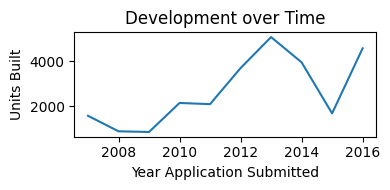

In [22]:
plt.figure(figsize=(4, 2))
plt.plot(result.groupby('year').agg({'Net_Units_Completed': 'sum'}))
plt.ylabel('Units Built')
plt.xlabel('Year Application Submitted')
plt.title('Development over Time')
plt.tight_layout()
plt.savefig('./development_over_time.png')

In [23]:
result.Developed = result.permit_number.notna()

In [24]:
result.Developed.sum()

1831

### EDA

In [25]:
result['revenue'] = result['sqft_price'] * result['Envelope_1000'] * 1000
result['costs'] = result['construction_cost_est'] + result['imputed_fair_market_acquisition']
result['r/c'] = result['revenue'] / result['costs']

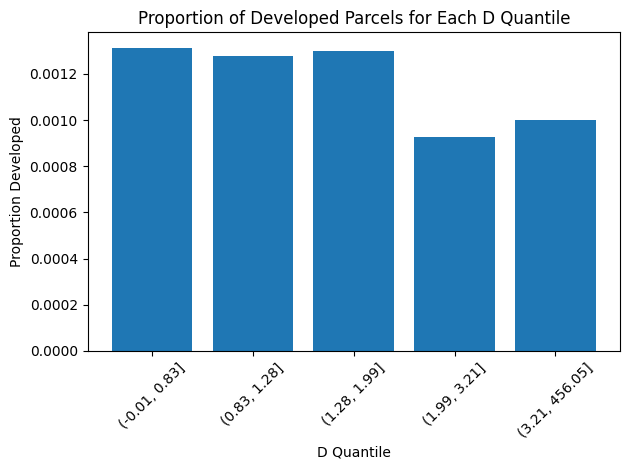

In [166]:
plot_data = result[['r/c', 'Developed']].copy()
plot_data = plot_data[plot_data['r/c'].notna()]
plot_data['r/c'] = pd.qcut(plot_data['r/c'], q=5, precision=2).astype(str)

# Calculate proportion of developed parcels
grouped = plot_data.groupby('r/c')['Developed'].mean().reset_index()
# Plotting
plt.bar(grouped['r/c'], grouped['Developed'])
plt.xlabel('D Quantile')
plt.ylabel('Proportion Developed')
plt.title('Proportion of Developed Parcels for Each D Quantile')
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures that labels fit within the plot area
plt.savefig('d_vs_proportion_developed.png')

In [34]:
(result[['revenue']].describe() / 100000).round(1)

,revenue
count,15.2
mean,30.3
std,206.4
min,0.0
25%,5.8
50%,8.3
75%,16.5
max,26005.3


In [37]:
(result[['construction_cost_est']].describe() / 100zzz00).round(1)

,construction_cost_est
count,15.3
mean,8.9
std,48.9
min,0.0
25%,0.8
50%,1.3
75%,2.4
max,8000.0


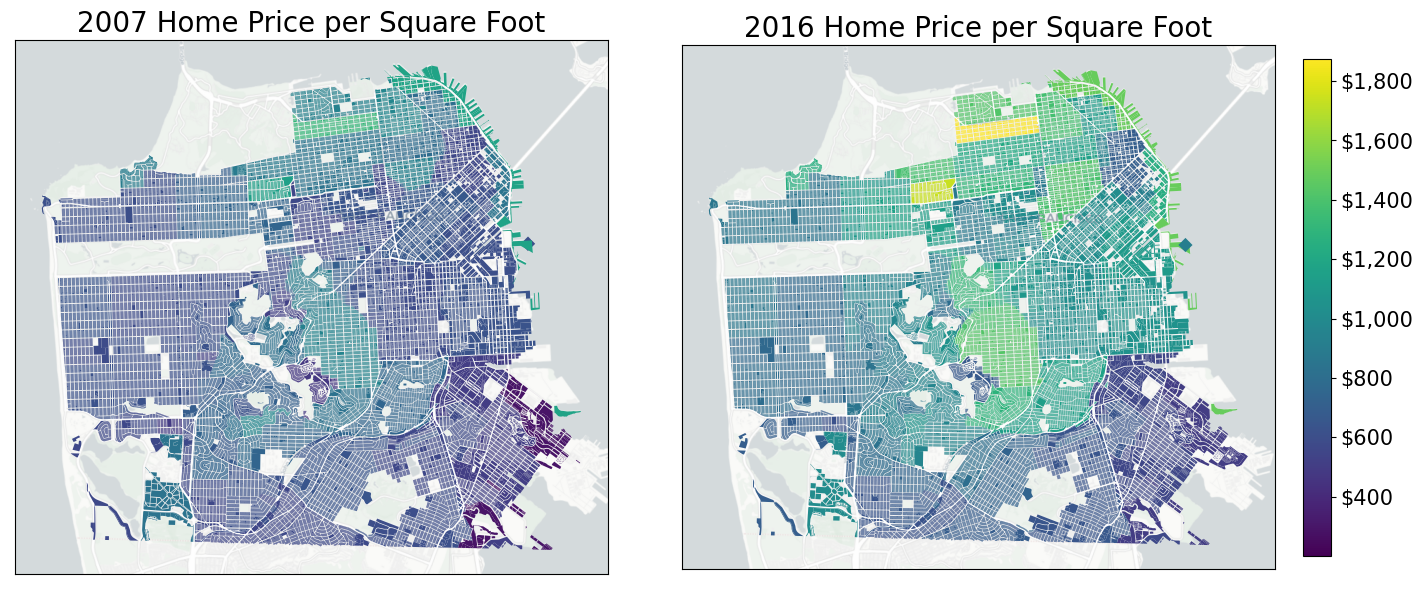

In [60]:
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True, gridspec_kw={'wspace': 0.125})
fig.subplots_adjust(left=0.0)
vmin, vmax = panel['sqft_price'].min(), panel['sqft_price'].max()

ax1 = panel.query('closed_roll_year == 2016').plot(column='sqft_price', legend=False, ax=axes[1], vmin=vmin, vmax=vmax)
ctx.add_basemap(crs=3310, attribution=False, source=ctx.providers.CartoDB.Positron, ax=axes[1])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("2016 Home Price per Square Foot", fontsize=20)

ax2 = panel.query('closed_roll_year == 2007').plot(column='sqft_price', legend=False, ax=axes[0], vmin=vmin, vmax=vmax)
ctx.add_basemap(crs=3310, attribution=False, source=ctx.providers.CartoDB.Positron, ax=axes[0])
ax2.set_xticks([])
ax2.set_yticks([]) 
ax2.set_title("2007 Home Price per Square Foot", fontsize=20)

cax = fig.add_axes([0.92, 0.14, 0.02, 0.71])  
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
formatter = FuncFormatter(lambda x, pos: f"${x:,.0f}")
cbar.ax.yaxis.set_major_formatter(formatter)
cbar.ax.tick_params(labelsize=15)

plt.savefig('combined_sqft_price.png')

In [36]:
result[['imputed_fair_market_acquisition']].describe().round(2)

,imputed_fair_market_acquisition
count,15.2
mean,8.5
std,54.6
min,0.0
25%,1.7
50%,4.2
75%,7.8
max,8680.2


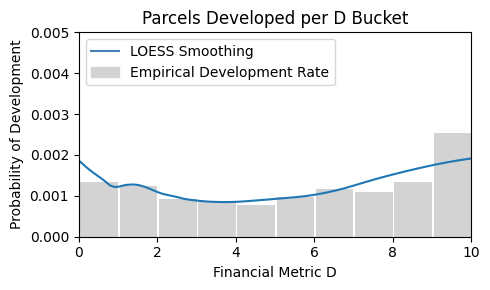

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from matplotlib.patches import Patch 
from matplotlib.lines import Line2D

# Preparing the data
plot_data = result[['r/c', 'Developed']].copy()
plot_data = plot_data[plot_data['r/c'].notna()]
plot_data['Developed'] = plot_data['Developed'].astype(int)

# Prepare data for LOESS
x = plot_data['r/c'].values
y = plot_data['Developed'].values

# Fit LOESS model
lowess_results = sm.nonparametric.lowess(y, x, frac=0.5, it=0, delta=.1)  # Adjust the frac parameter as needed

# Generate new data for predictions
upper_bound = plot_data['r/c'].quantile(.99).round()
x_pred = np.linspace(plot_data['r/c'].min(), upper_bound, 100)

# Calculate mean 'Developed' value for each 'r/c' bucket
bucket_width = 1
buckets = np.arange(0, upper_bound, bucket_width)
mean_developed_per_bucket = [plot_data[(plot_data['r/c'] >= left) & 
                                       (plot_data['r/c'] < left + bucket_width)]['Developed'].mean() 
                            for left in buckets]

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(lowess_results[:, 0], 
         np.maximum(lowess_results[:, 1], np.zeros_like(lowess_results[:, 1].flatten())), 
         label='Predicted probabilities')

# Add vertical bars
for i, left in enumerate(buckets):
    dev_rate = mean_developed_per_bucket[i]
    plt.bar(left + 0.52, dev_rate, facecolor='lightgrey', width=.96)

# Legend
plt.legend(handles=[Line2D([0], [0], linestyle='-', color='steelblue', 
                           label='LOESS Smoothing', markersize=10),
                    Patch(color='lightgrey', label='Empirical Development Rate')], loc='upper left')

# Labels and Title
plt.xlabel('Financial Metric D', fontsize=10)
plt.xlim((0, upper_bound))
plt.ylim((0, .005))  # You might need to adjust this based on your data
plt.ylabel('Probability of Development', fontsize=10)
plt.title('Parcels Developed per D Bucket')

# Save the plot
plt.tight_layout()
plt.savefig('./development_vs_D.png', bbox_inches='tight')

# Show the plot
plt.show()


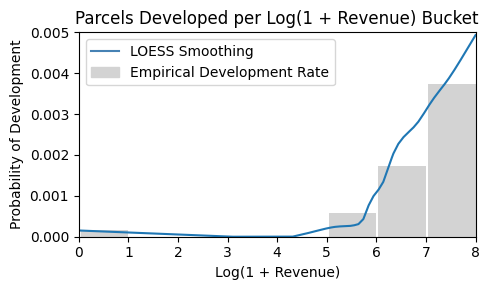

In [78]:
import statsmodels.api as sm
from matplotlib.patches import Patch 
from matplotlib.lines import Line2D

plot_data = result[['revenue', 'Developed']].copy()
plot_data = plot_data[plot_data['revenue'].notna()]
plot_data['Developed'] = plot_data['Developed'].astype(int)
plot_data['log_revenue'] = np.log10(1 + plot_data['revenue'])

# Prepare data for LOESS
x = plot_data['log_revenue'].values
y = plot_data['Developed'].values

# Fit LOESS model
lowess_results = sm.nonparametric.lowess(y, x, frac=0.5, it=0, delta=.1)  # Adjust the frac parameter as needed

# Generate new data for predictions
upper_bound = plot_data['log_revenue'].quantile(.99).round()
x_pred = np.linspace(plot_data['log_revenue'].min(), upper_bound, 100)

# Calculate mean 'Developed' value for each log_revenue bucket
bucket_width = 1
buckets = np.arange(0, upper_bound, bucket_width)
mean_developed_per_bucket = [plot_data[(plot_data['log_revenue'] >= left) & 
                                       (plot_data['log_revenue'] < left + bucket_width)]['Developed'].mean() 
                            for left in buckets]

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(lowess_results[:, 0], 
         np.maximum(lowess_results[:, 1], np.zeros_like(lowess_results[:, 1].flatten())), 
         label='Predicted probabilities')

# Add vertical bars
for i, left in enumerate(buckets):
    dev_rate = mean_developed_per_bucket[i]
    plt.bar(left + 0.52, dev_rate, facecolor='lightgrey', width=.96)

# Legend
plt.legend(handles=[Line2D([0], [0], linestyle='-', color='steelblue', 
                           label='LOESS Smoothing', markersize=10),
                    Patch(color='lightgrey', label='Empirical Development Rate')], loc='upper left')

# Labels and Title
plt.xlabel('Log(1 + Revenue)', fontsize=10)
plt.xlim((0, upper_bound))
plt.ylim((0, .005))
plt.ylabel('Probability of Development', fontsize=10)
plt.title('Parcels Developed per Log(1 + Revenue) Bucket')

# Save the plot
plt.tight_layout()
plt.savefig('./development_vs_revenue.png', bbox_inches='tight')

# Show the plot
plt.show()


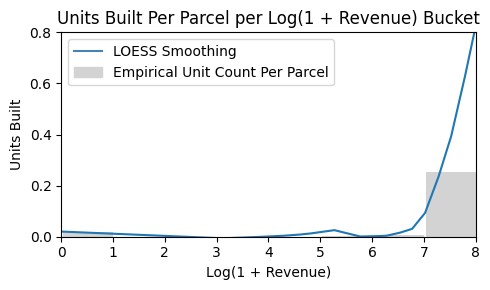

In [79]:
import statsmodels.api as sm
from matplotlib.patches import Patch 
from matplotlib.lines import Line2D

plot_data = result[['revenue', 'Net_Units_Completed']].copy()
plot_data = plot_data[plot_data['revenue'].notna()]
plot_data['Net_Units_Completed'] = plot_data['Net_Units_Completed'].astype(int)
plot_data['log_revenue'] = np.log10(1 + plot_data['revenue'])

# Prepare data for LOESS
x = plot_data['log_revenue'].values
y = plot_data['Net_Units_Completed'].values

# Fit LOESS model
lowess_results = sm.nonparametric.lowess(y, x, frac=0.3, it=0, delta=.25)  # Adjust the frac parameter as needed

# Generate new data for predictions
upper_bound = plot_data['log_revenue'].quantile(.99).round()
x_pred = np.linspace(plot_data['log_revenue'].min(), upper_bound, 100)

# Calculate mean 'Developed' value for each log_revenue bucket
bucket_width = 1
buckets = np.arange(0, upper_bound, bucket_width)
mean_developed_per_bucket = [plot_data[(plot_data['log_revenue'] >= left) & 
                                       (plot_data['log_revenue'] < left + bucket_width)]['Net_Units_Completed'].mean() 
                            for left in buckets]

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(lowess_results[:, 0], lowess_results[:, 1], label='Predicted Units Built')

# Add vertical bars
for i, left in enumerate(buckets):
    dev_rate = mean_developed_per_bucket[i]
    plt.bar(left + 0.52, dev_rate, facecolor='lightgrey', width=.96)

# Legend
plt.legend(handles=[Line2D([0], [0], linestyle='-', color='steelblue', 
                           label='LOESS Smoothing', markersize=10),
                    Patch(color='lightgrey', label='Empirical Unit Count Per Parcel')], loc='upper left')

# Labels and Title
plt.xlabel('Log(1 + Revenue)', fontsize=10)
plt.xlim((0, upper_bound))
plt.ylim((0, .8))
plt.ylabel('Units Built', fontsize=10)
plt.title('Units Built Per Parcel per Log(1 + Revenue) Bucket')

# Save the plot
plt.tight_layout()
plt.savefig('./production_vs_revenue.png', bbox_inches='tight')

# Show the plot
plt.show()


In [247]:
result.property_class_code_definition.nunique()

101

In [203]:
model

In [62]:
plot_data = panel[['costs', 'Developed']].copy()
plot_data = plot_data[plot_data['costs'].notna()]
plot_data['costs'] = pd.qcut(np.log10(1 + plot_data['costs']), q=10, precision=2).astype(str)

# Calculate proportion of developed parcels
grouped = plot_data.groupby('costs')['Developed'].mean().reset_index()
grouped

,costs,Developed
0,"(4.74, 5.36]",0.000000
1,"(5.36, 5.51]",0.000007
2,"(5.51, 5.62]",0.000000
3,"(5.62, 5.71]",0.000007
4,"(5.71, 5.79]",0.000026
5,"(5.79, 5.87]",0.000040
6,"(5.87, 5.96]",0.000053
7,"(5.96, 6.08]",0.000079
8,"(6.08, 6.3]",0.000461
9,"(6.3, 8.96]",0.001443


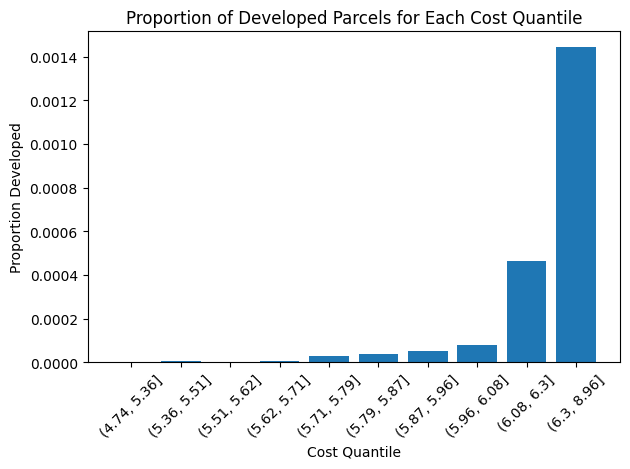

In [63]:
# Plotting
plt.bar(grouped['costs'], grouped['Developed'])
plt.xlabel('Cost Quantile')
plt.ylabel('Proportion Developed')
plt.title('Proportion of Developed Parcels for Each log(Cost) Quantile')
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures that labels fit within the plot area
plt.show()

In [83]:
df = result[['revenue', 'costs', 'Developed', 'Net_Units_Completed']].copy()
# Create terciles for 'revenue' and 'costs'
df['revenue_tercile'] = pd.qcut(df['revenue'], q=3, labels=['Low', 'Medium', 'High'])
df['costs_tercile'] = pd.qcut(df['costs'], q=3, labels=['Low', 'Medium', 'High'])

# Calculate the average 'Developed' value for each (revenue_tercile, costs_tercile) pair
grouped = df.groupby(['revenue_tercile', 'costs_tercile'])['Developed'].mean().reset_index()


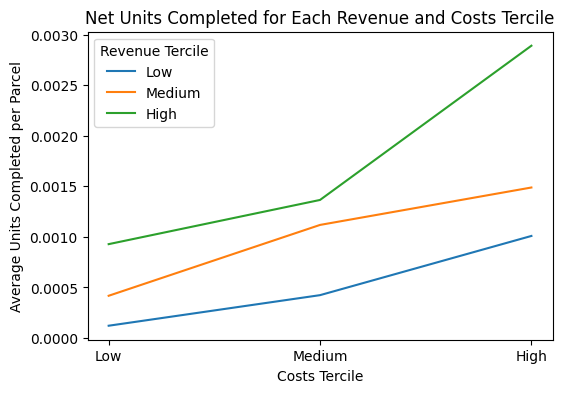

In [85]:
# Create the plot
plt.figure(figsize=(6, 4))

for label, df_subset in grouped.groupby('revenue_tercile'):
    plt.plot(df_subset['costs_tercile'], df_subset['Developed'], label=label)

plt.title('Net Units Completed for Each Revenue and Costs Tercile')
plt.xlabel('Costs Tercile', fontsize=10)
plt.ylabel('Average Units Completed per Parcel', fontsize=10)
plt.legend(title='Revenue Tercile')

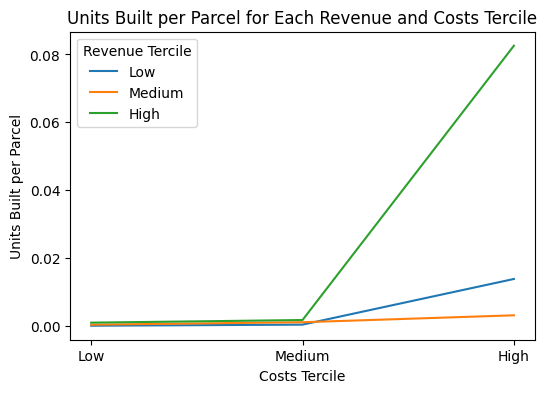

In [86]:
# Group data by 'revenue_tercile' and 'costs_tercile' and calculate the mean of 'net_units_completed'
grouped = df.groupby(['revenue_tercile', 'costs_tercile'])['Net_Units_Completed'].mean().reset_index()

# Create the plot
plt.figure(figsize=(6, 4))

for label, df_subset in grouped.groupby('revenue_tercile'):
    plt.plot(df_subset['costs_tercile'], df_subset['Net_Units_Completed'], label=label)

plt.title('Units Built per Parcel for Each Revenue and Costs Tercile')
plt.xlabel('Costs Tercile', fontsize=10)
plt.ylabel('Units Built per Parcel', fontsize=10)
plt.legend(title='Revenue Tercile')
plt.savefig('./revenue_vs_cost_interact.png')

/var/folders/3l/rp3b9_z94lz520zv0rrb_0ww0000gn/T/ipykernel_52119/3574695258.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = grouped.pivot('costs_tercile', 'revenue_tercile', 'Net_Units_Completed')


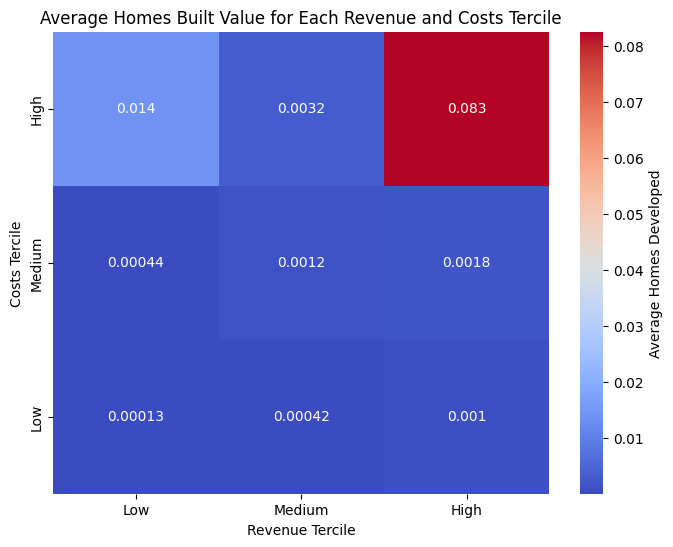

In [101]:
df = result[['revenue', 'costs', 'Developed', 'Net_Units_Completed']].copy()
# Create terciles for 'revenue' and 'costs'
df['revenue_tercile'] = pd.qcut(df['revenue'], q=3, labels=['Low', 'Medium', 'High'])
df['costs_tercile'] = pd.qcut(df['costs'], q=3, labels=['Low', 'Medium', 'High'])

# Calculate the average 'Developed' value for each (revenue_tercile, costs_tercile) pair
grouped = df.groupby(['revenue_tercile', 'costs_tercile'])['Net_Units_Completed'].mean().reset_index()

In [3]:
panel.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

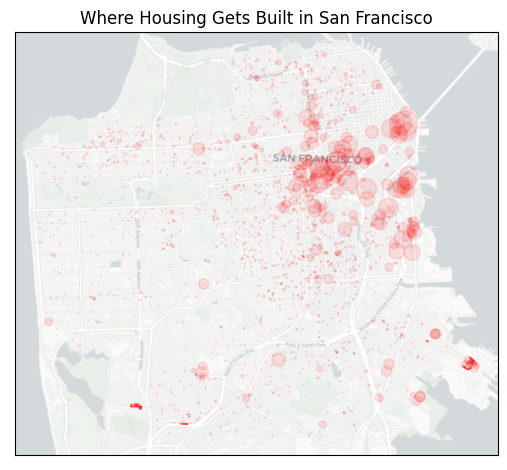

In [152]:
built = result[result.Net_Units_Completed > 0].copy()
built['log(Units Built)'] = np.log10(built.Net_Units_Completed)
ax1 = built['geometry'].centroid.plot(marker='o', color='red', markersize=built.Net_Units_Completed*.5, alpha=.1, label="Centroid")
ctx.add_basemap(crs=3310, attribution=False, source=ctx.providers.CartoDB.Positron, ax=ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Where Housing Gets Built in San Francisco")
plt.tight_layout()
plt.savefig('./where_housing_gets_built.png')

### Fires

In [88]:
fires = gpd.read_feather('../data/clean_accidental_fires.geofeather')

In [89]:
fires.to_crs(result.crs, inplace=True)

In [90]:
panel_fires = gpd.sjoin(result,
                        fires[['geometry',
                               'estimated_property_loss',
                               'incident_date']].rename(columns= 
                                                        {'estimated_property_loss' : 'fire_damage', 
                                                         'incident_date': 'fire_date'}), 
                        how='left',
                        predicate='contains')

In [91]:
panel_fires.index_right.notna().sum()

3479

In [92]:
panel_fires.drop_duplicates('MapBlkLot_Master')[
    (panel_fires.drop_duplicates('MapBlkLot_Master').fire_damage > 0)
].fire_damage.describe()

count    3.020000e+02
mean     8.714212e+04
std      7.710259e+05
min      1.000000e+00
25%      5.000000e+02
50%      2.000000e+03
75%      1.150000e+04
max      1.320000e+07
Name: fire_damage, dtype: float64

In [93]:
panel_fires = panel_fires.drop(columns=['index_right'])

In [94]:
panel_fires.fire_damage.fillna(0, inplace=True)

In [95]:
panel_fires['years_since_fire'] = panel_fires.year - panel_fires.fire_date.dt.year

In [96]:
panel_fires['years_since_fire'][panel_fires['years_since_fire'].notna()]

278        -4.0
1982       -7.0
5338      -11.0
10078      -6.0
11812     -10.0
           ... 
1526412    -5.0
1526466     9.0
1528836    -1.0
1529871    -6.0
1530706    11.0
Name: years_since_fire, Length: 3479, dtype: float64

In [97]:
panel_fires['years_since_fire'][panel_fires['years_since_fire'].notna()].describe()

count    3479.000000
mean        0.574590
std         6.663876
min       -16.000000
25%        -4.000000
50%         2.000000
75%         6.000000
max        13.000000
Name: years_since_fire, dtype: float64

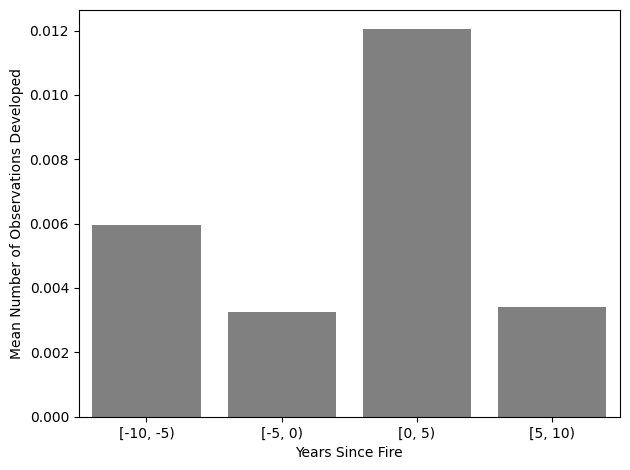

In [98]:
# Compute the mean for each unique value of 'years_since_fire'
to_plot = panel_fires.copy()
to_plot['years_since_fire_bucket'] = pd.cut(to_plot['years_since_fire'], bins=range(-10, 11, 5), right=False)
to_plot = to_plot.groupby('years_since_fire_bucket')['Developed'].mean().reset_index()

# Plot using seaborn
sns.barplot(x='years_since_fire_bucket', y='Developed', data=to_plot, color='grey')
plt.ylabel('Mean Number of Observations Developed')
plt.xlabel('Years Since Fire')
plt.tight_layout()
plt.savefig('./dev_after_fire.png')

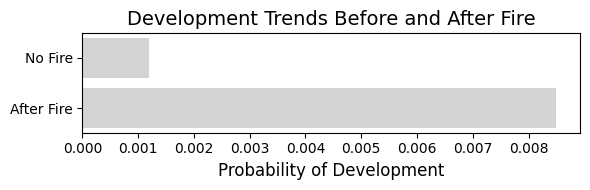

In [114]:
panel_fires['fire_category'] = np.where(panel_fires['years_since_fire'].fillna(-1) < 0, 'No Fire', 'After Fire')
plt.figure(figsize=(6, 2))

# Compute the mean for each category
plot_data = panel_fires.groupby('fire_category')['Developed'].mean().reset_index()

plot_data
# Plot using matplotlib
plt.barh(plot_data['fire_category'], plot_data['Developed'], color='lightgrey')

# Set y-axis limit to 105% of the maximum value
plt.xlim(0, plot_data['Developed'].max() * 1.05)
plt.xlabel('Probability of Development', fontsize=12)
plt.title('Development Trends Before and After Fire', fontsize=14)
plt.tight_layout()
plt.savefig('dev_fire_fstat.png')

In [18]:
0.008499 / 0.001190

7.142016806722689

### Revenue & Cost

In [64]:
panel_fires['revenue'] = panel_fires['sqft_price'] * panel_fires['Envelope_1000'] * 1000 / 30

In [65]:
panel_fires.columns

Index(['MapBlkLot_Master', 'year', 'Developed', 'Historic',
       'Residential_Dummy', 'Zillow_Price_Real', 'Const_FedReserve_Real',
       'Envelope_1000', 'Upzone_Ratio', 'zp_OfficeComm', 'zp_DensRestMulti',
       'zp_FormBasedMulti', 'zp_PDRInd', 'zp_Public', 'zp_Redev', 'zp_RH2',
       'zp_RH3_RM1', 'geometry', 'mapblklot', 'property_class_code_definition',
       'lot_code', 'property_area', 'volume_number', 'percent_of_ownership',
       'misc_exemption_value', 'zoning_code', 'year_property_built',
       'analysis_neighborhood', 'number_of_units', 'use_definition',
       'closed_roll_year', 'status_code', 'number_of_bedrooms',
       'assessor_neighborhood', 'number_of_stories',
       'assessor_neighborhood_district', 'exemption_code_definition', 'block',
       'current_sales_date', 'lot_area', 'number_of_rooms', 'lot_depth',
       'assessed_personal_property_value', 'supervisor_district_2012',
       'number_of_bathrooms', 'construction_type', 'lot_frontage',
       'hom

In [66]:
panel_fires['costs'] = (panel_fires['construction_cost_est'] 
                        + np.maximum(panel_fires['imputed_fair_market_acquisition'] - panel_fires['fire_damage'], 0))

In [67]:
panel_fires['costs']

0          2.495993e+07
1          5.287091e+07
2          3.151963e+05
3          1.025149e+06
4          7.382555e+05
               ...     
1530789    6.903314e+05
1530790    2.785223e+06
1530791    1.040481e+06
1530792    1.891363e+06
1530793             NaN
Name: costs, Length: 1531273, dtype: float64

In [68]:
panel_fires['revenue'] 

0          3.372075e+06
1          2.744964e+06
2          3.782784e+04
3          3.927322e+04
4          5.971198e+04
               ...     
1530789    1.250667e+05
1530790    1.293656e+05
1530791    1.421000e+05
1530792    4.898656e+05
1530793             NaN
Name: revenue, Length: 1531273, dtype: float64

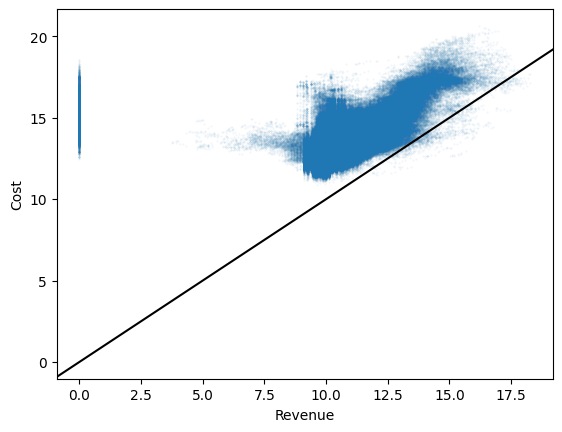

In [69]:
f, ax = plt.subplots()
plt.scatter(np.log1p(panel_fires['revenue']), np.log1p(panel_fires['costs']), alpha=.1, s=.1)
plt.xlabel('Revenue')
plt.ylabel('Cost')
ax.axline((0, 0), slope=1, color='black')
plt.show()

In [55]:
panel_fires['fire_damage'].max()

13200000.0

In [39]:
panel_fires['revenue'].max()

2600526059.778

KeyboardInterrupt: 

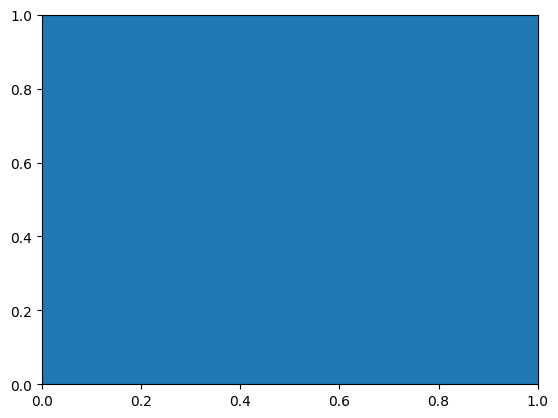

In [40]:
plt.hist(np.log1p(panel_fires['revenue'] / panel_fires['costs']), bins=40)
plt.xlim(0, 100)

In [ ]:
result = panel_fires.groupby('Developed').apply(lambda x: (x['revenue'] / x['costs']).mean())

# Create the bar plot
result.plot(kind='bar', ylabel='Mean Revenue / Costs', title='Mean Revenue Divided by Costs for Developed and Not Developed Groups')
plt.xticks(ticks=[0, 1], labels=['Not Developed', 'Developed'], rotation=0)
plt.show()

In [3]:
panel_fires = pd.read_csv('./panel_fires.csv')

/var/folders/3l/rp3b9_z94lz520zv0rrb_0ww0000gn/T/ipykernel_47521/3647980955.py:1: DtypeWarning: Columns (37,66,67,68,69,72) have mixed types. Specify dtype option on import or set low_memory=False.
  panel_fires = pd.read_csv('./panel_fires.csv')


In [ ]:
panel_fires.to_csv('./panel_fires.csv', index=False)